# Project 2 - Multiple Myeloma Survival


In [5]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os

In [6]:
df = pd.read_csv('./data/train_data.csv')

In [7]:

def create_submission_file(predictions, filename):
    """
    Create a submission file with predictions.
    
    Args:
        predictions (array-like): The predicted values for SurvivalTime.
        filename (str): The name of the output file.
    """
    # Load the sample submission to get the 'Id' column structure
    sample_submission = pd.read_csv('./data/sample_submission.csv')

    # Ensure that predictions are a single column (reshape if necessary)
    predictions = pd.Series(predictions).values
    
    # Create the submission DataFrame
    submission = pd.DataFrame(columns=sample_submission.columns) 
    submission['id'] = range(len(predictions))
    submission['0'] = predictions # Add the predictions to the 'SurvivalTime' column

    # Save the DataFrame to CSV
    os.makedirs("./results", exist_ok=True)
    submission.to_csv(f'./results/{filename}', index=False)

    print(f"File Created: ./results/{filename}")


## Task 1 - Setting the baseline

### Task 1.1 - Data preparation and validation pipeline


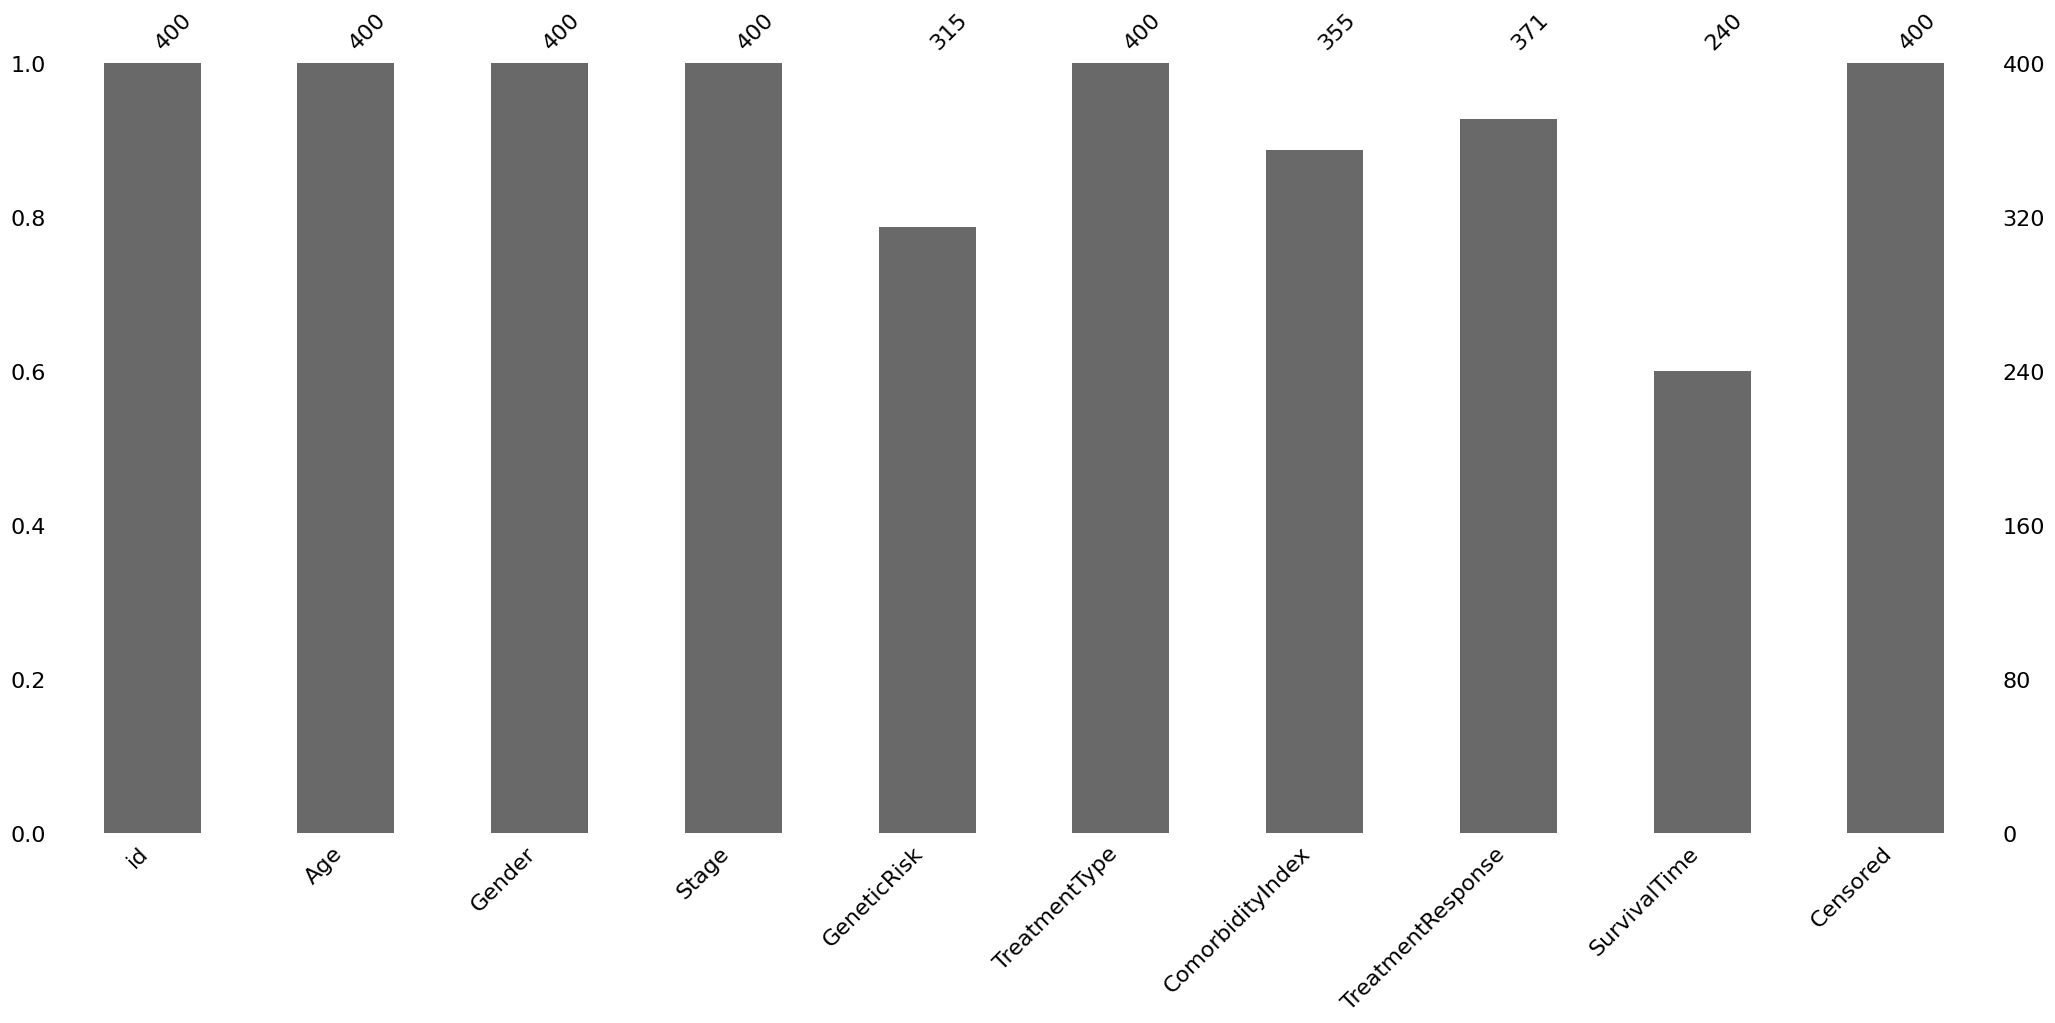

In [8]:
# Simple visualization of missing values

msno.bar(df)
plt.show()

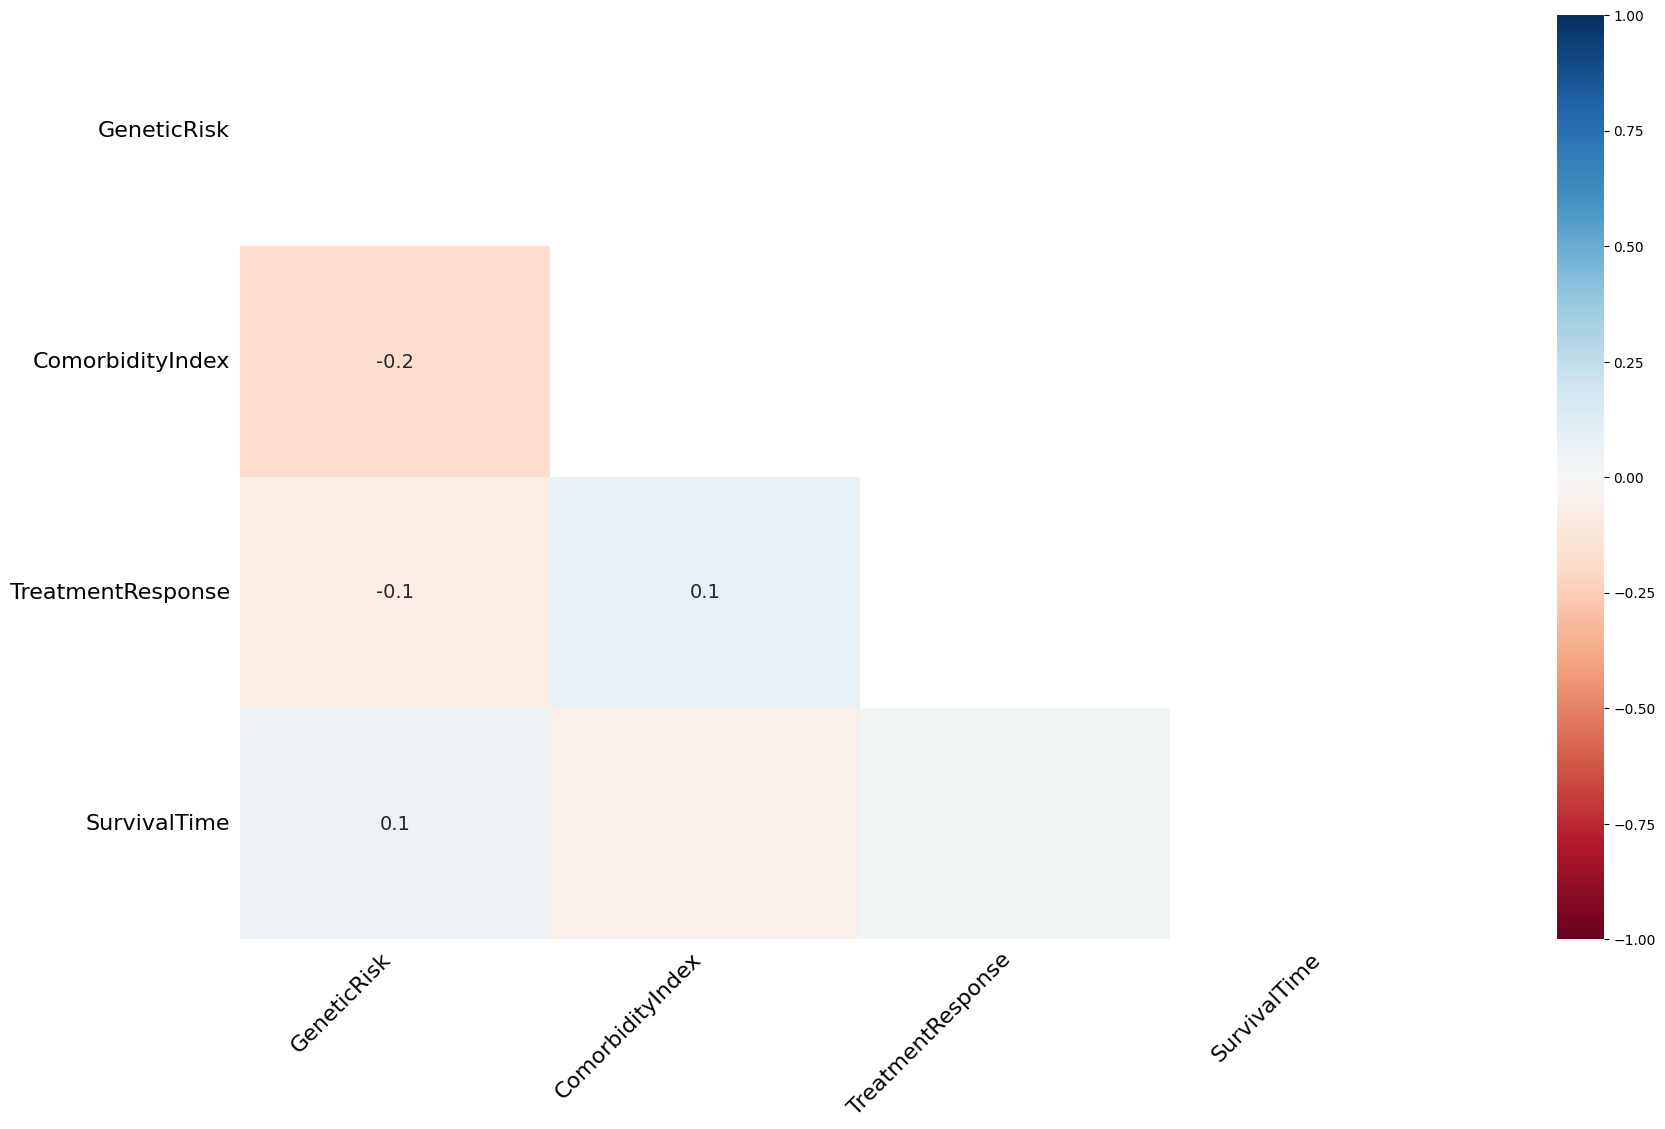

In [9]:
#Simple visualization of missing values

msno.heatmap(df)
plt.show()

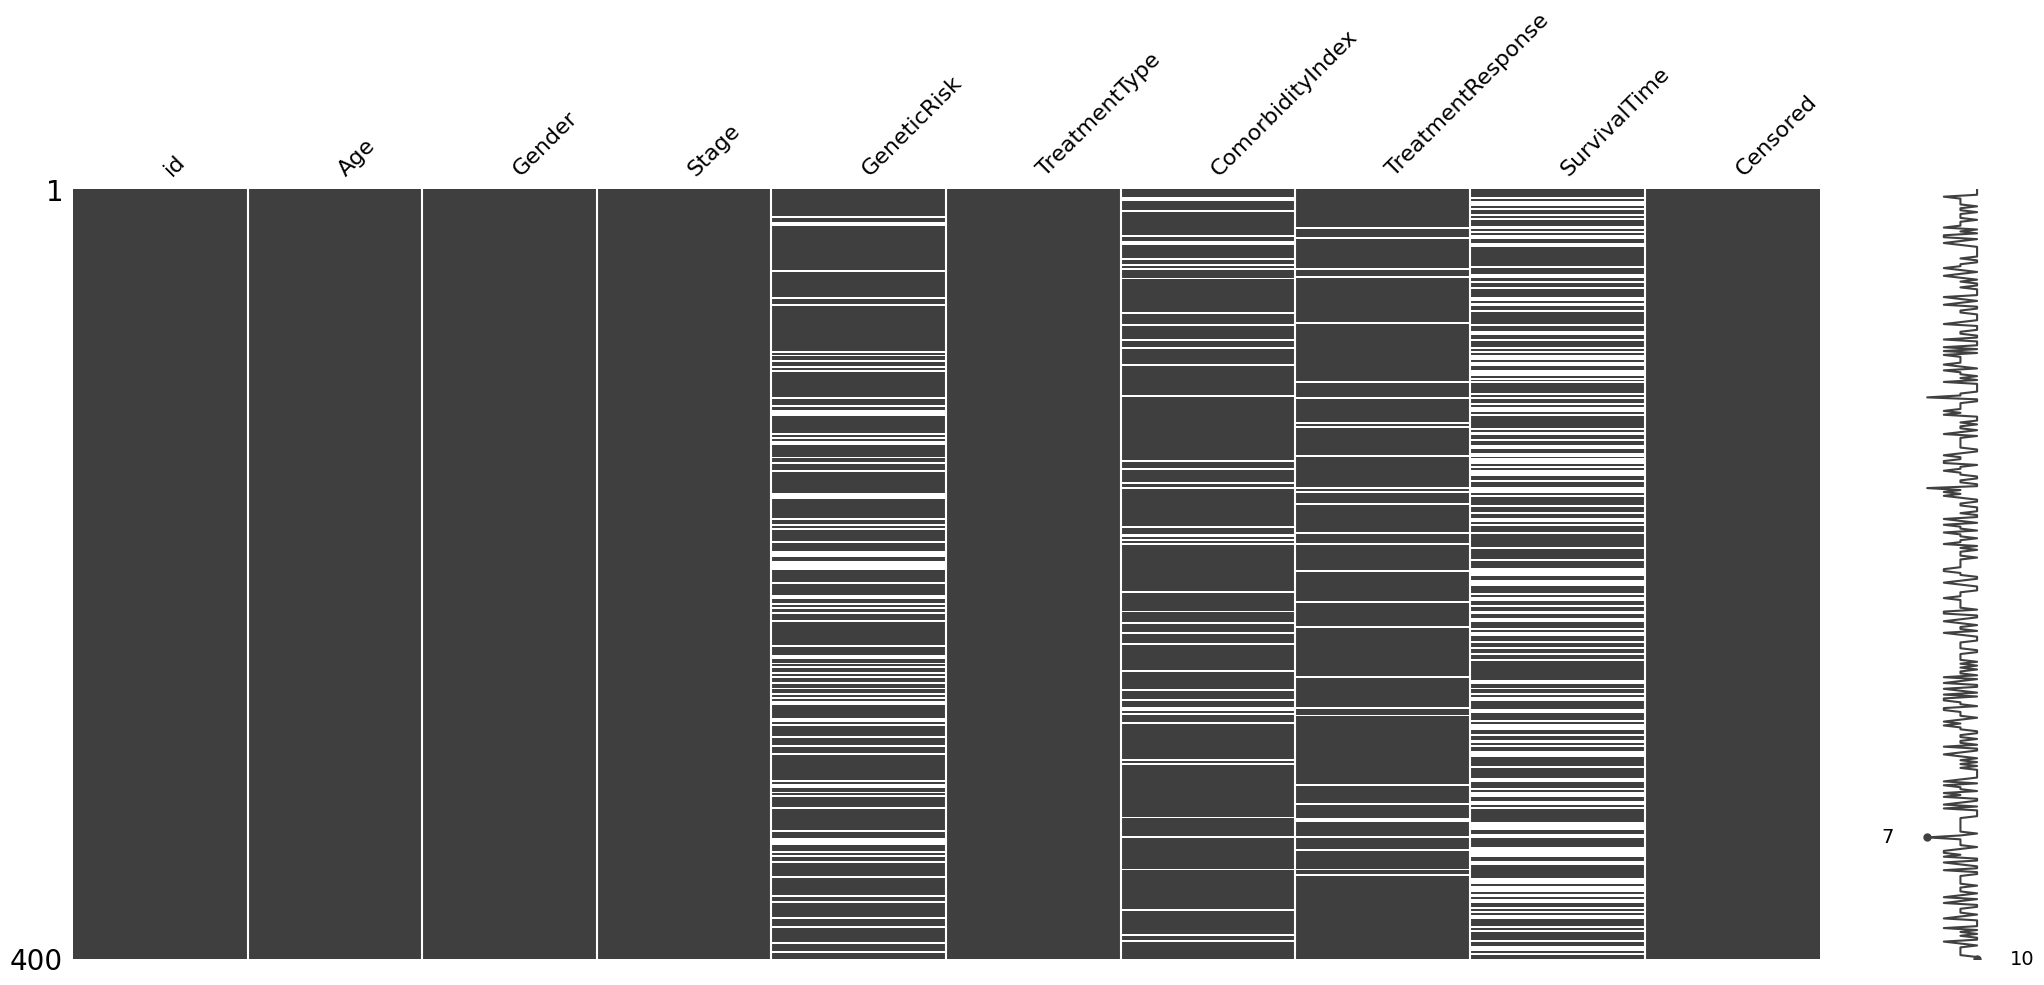

In [10]:
#Simple visualization of missing values

msno.matrix(df)
plt.show()

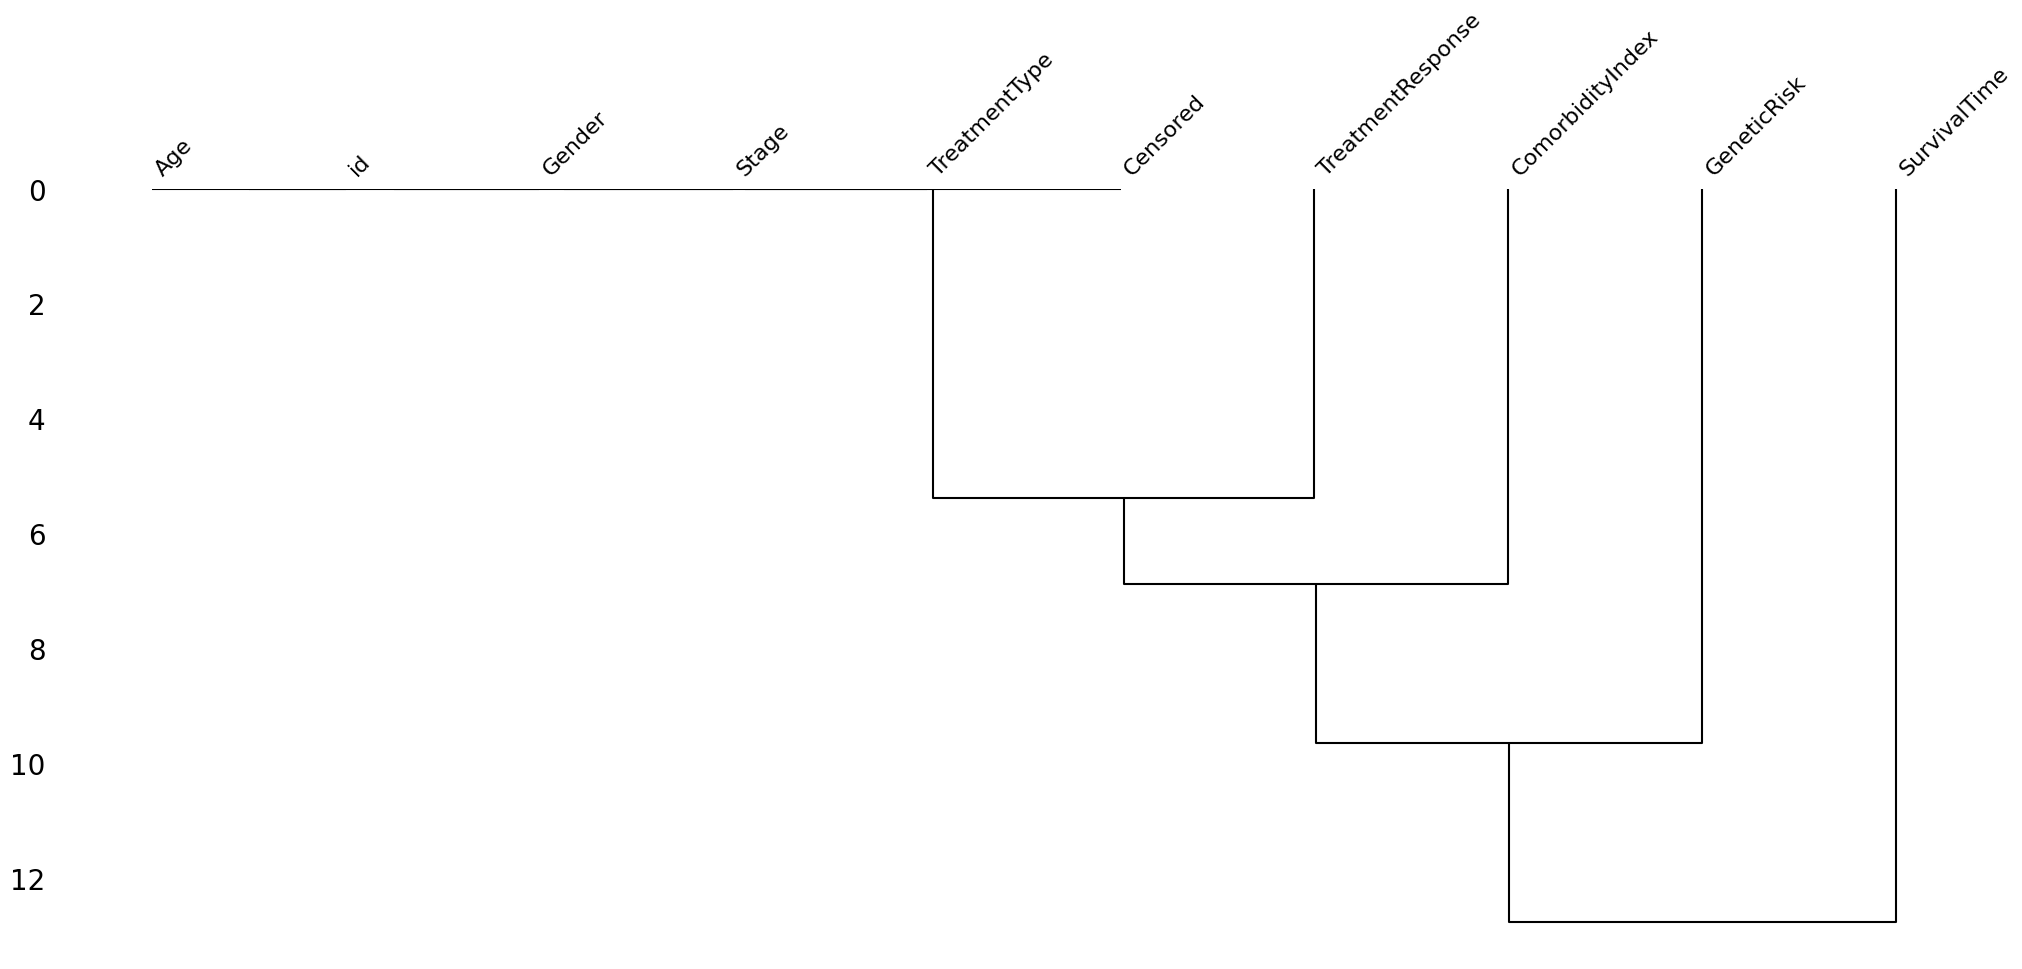

In [11]:
#Simple visualization of missing values

msno.dendrogram(df)
plt.show()

Remaining data points after dropping: 161


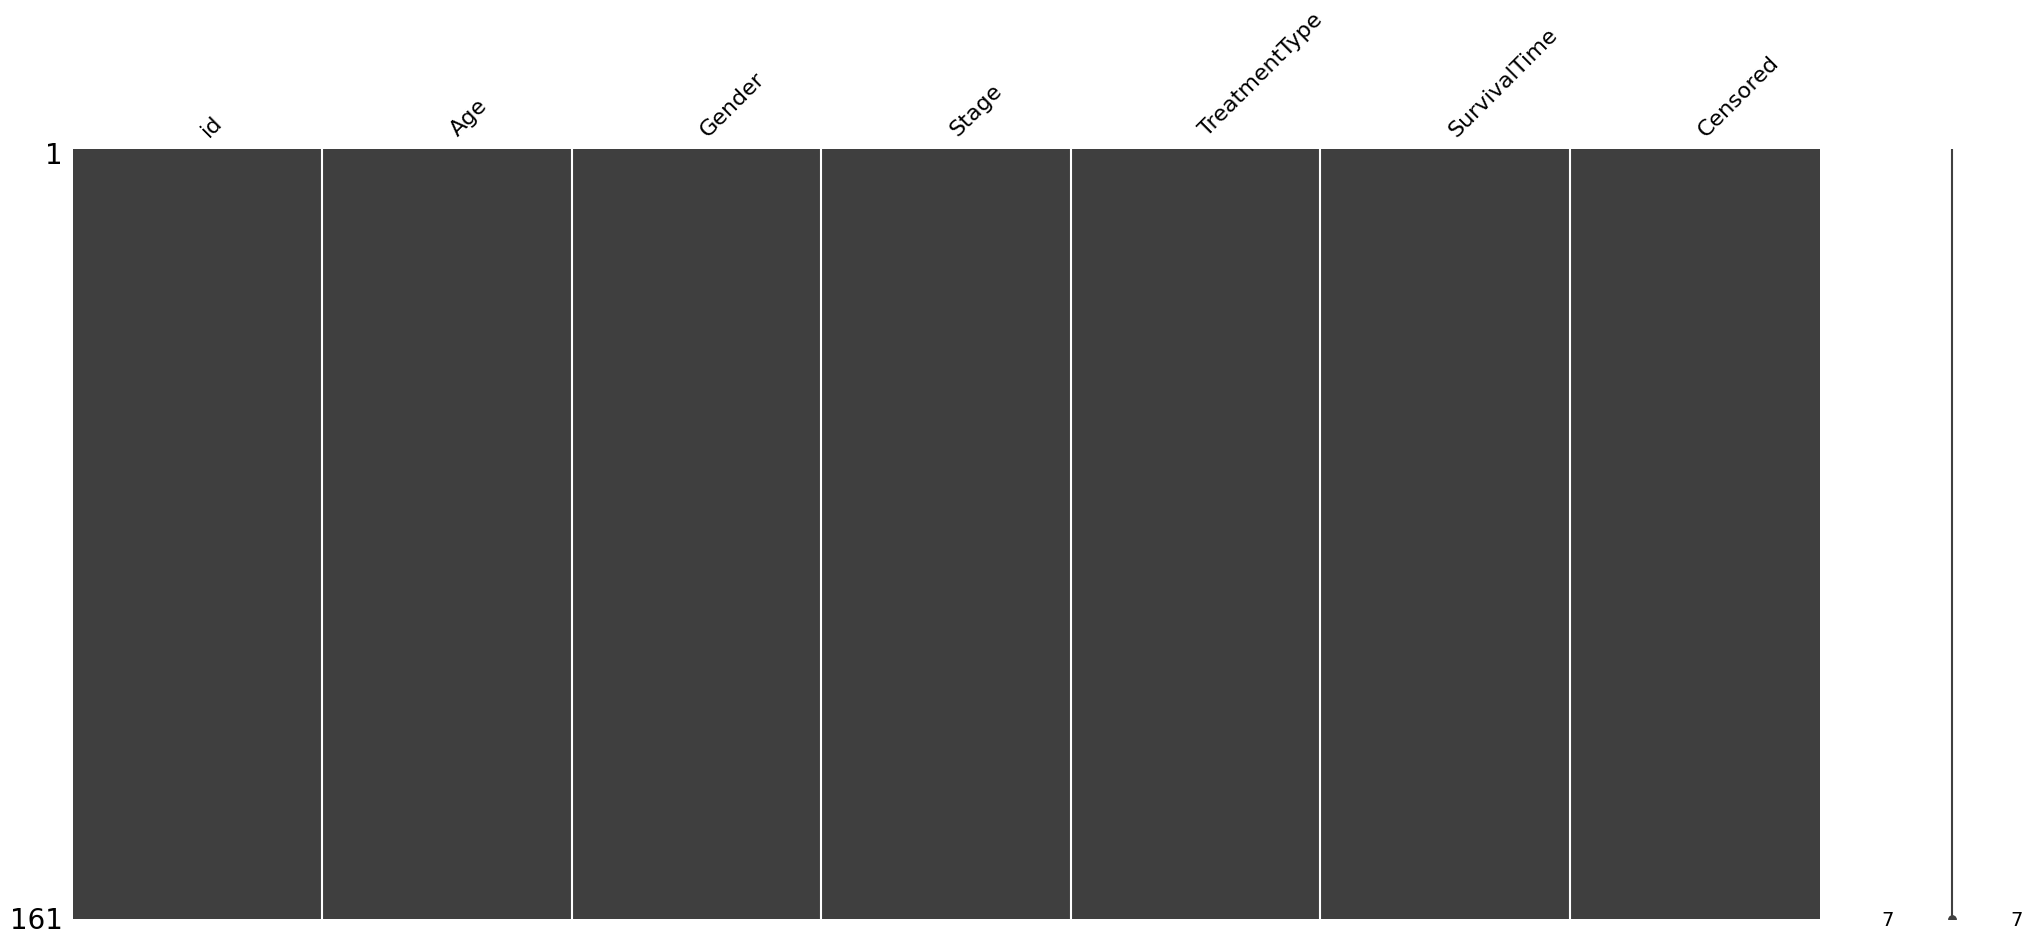

In [12]:
# Drop rows with missing 'SurvivalTime' values
df_cleaned = df[df['SurvivalTime'].notnull()]

# Drop columns with missing data (for the baseline task 1.1)
df_cleaned = df_cleaned.dropna(axis=1)  # Drop columns with any missing data

# Drop rows where 'Censored' is 1 (Censoring occurs when the exact time of an event of interest (such as death or disease recurrence) is unknown)
df_cleaned = df_cleaned[(df_cleaned['Censored']== 0)]

#answering how many data points remain after dropping?
print(f"Remaining data points after dropping: {df_cleaned.shape[0]}")


msno.matrix(df_cleaned)
plt.show()

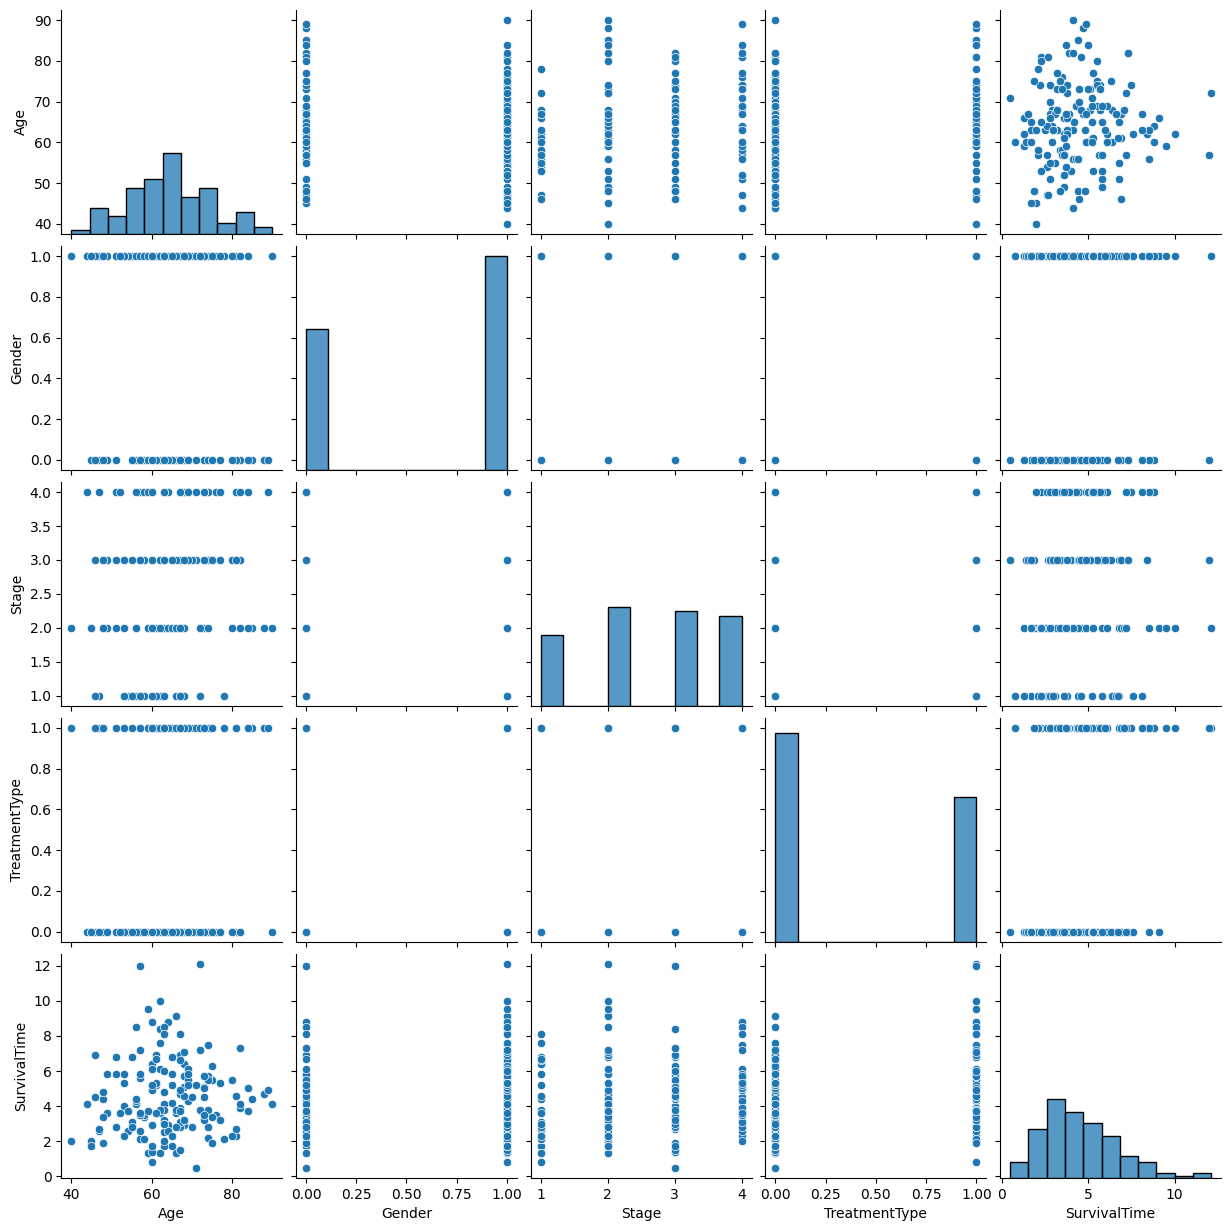

In [13]:
#scattter plots and diagonal histograms

#we dont put here the Censored because its a label indicator(which is not a feature for prediction, but a flag for censoring)
sns.pairplot(df_cleaned, vars=['Age', 'Gender', 'Stage','TreatmentType', 'SurvivalTime'])
plt.show()

In [14]:
# Define the feature matrix (X) and target vector (y)
X = df_cleaned.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Drop target and censoring indicator
y = df_cleaned['SurvivalTime']  # Target variable: survival time
censored = df_cleaned['Censored']  # Censoring indicator

In [15]:
#80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split training data into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Step 4: Evaluate on the validation set
y_val_pred = model1.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f'Validation MSE: {val_mse}')

# Step 5: Test the model on the test set
y_test_pred = model1.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test MSE: {test_mse}')



Validation Mean Squared Error: 3.3672081469531454
Test MSE: 5.047342256739609


In [17]:
# we can improve cv
# Use cross-validation with a linear regression model
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation with default scoring (R^2)
print(f"Cross-validation scores: {cv_scores}")

average_cv_score = np.mean(cv_scores)
print(f"Average Cross-validation Score: {average_cv_score}")


# Fit the model
model.fit(X, y)

# Evaluate on the test set
y_pred = model.predict(X)
test_cross_mse = mean_squared_error(y, y_pred)
print(f"Test MSE: {test_cross_mse}")

Cross-validation scores: [-0.15002761  0.13372435  0.01983757  0.09508242  0.06095934]
Average Cross-validation Score: 0.03191521329639211
Test MSE: 4.087307290510991


Comparing the Avarage MSE Cross validation value and the MSE value simple, with Cross Validation is more efficient without Cross Validation because in cross-validation, the model is trained and validated multiple times using different splits of the dataset. This means that the model gets to train on almost all of the data, which helps the model generalize better.


In [18]:
# Censored Mean Squared Error(we used this because for the censored cases we only know that the survival time is greater than some observed time)
# c = 0 for uncensored data points
# c = 1 for censored data points

def error_metric(y, y_hat, c):
    import numpy as np
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

# c is the censored variable 
#  y is the true Survival Time, as determined by the ground truth.
#  The variable y_hat contains the predicted Survival Time.

In [ ]:
# Calculate cMSE

# Without cross-validation
print("Without cross-validation")
test2_cmse = error_metric(y_test, y_test_pred,0)#reformular aqui o censored, neste caso meti a 0 porque conheco os dados 
print(f'Test cMSE: {test2_cmse}\n')


#With cross-validation
print("With cross-validation")
y_pred1 = model.predict(X)
test1_cmse = error_metric(y, y_pred1,censored)
print(f"Test cMSE: {test1_cmse}")



Without cross-validation
Test cMSE: 5.047342256739609

With cross-validation
Test cMSE: 4.087307290510991


we saw without cross-validation validation worst then test because of 2 possible reasons. Overfitting of the Valisdation Set or Random variablity in a single train/test split. Shows again that with cross-validation we try to coverage this cases with that solution. 

Note: we can change the split percentage to see if we can have a better result without cross-validation

### Task 1.2 - Learn the baseline model


MSE: 4.087307290510991
cMSE: 4.087307290510991


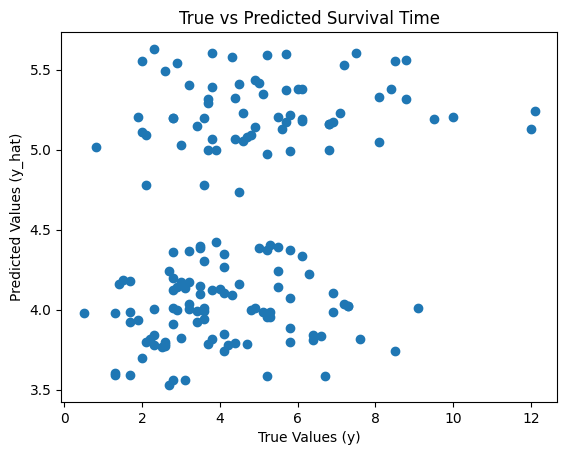

In [23]:
#Base Line model with cross-validation

# Create the pipeline with scaling and Linear Regression
pipeline = make_pipeline(
    StandardScaler(),  # Feature scaling
    LinearRegression()  # Linear regression model
)

# first try with r^2
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # 5-fold cross-validation


pipeline.fit(X, y)
y_pred = pipeline.predict(X)


mse = mean_squared_error(y, y_pred)
print(f"MSE: {mse}")
cMSE = error_metric(y, y_pred,censored)
print(f"cMSE: {cMSE}")

#create_submission_file(y_pred, 'baseline-submission-01.csv')

plt.scatter(y, y_pred)
plt.xlabel('True Values (y)')
plt.ylabel('Predicted Values (y_hat)')
plt.title('True vs Predicted Survival Time')
plt.show()



In [24]:
# submission task 1.2
df_test = pd.read_csv('./data/test_data.csv')
 # quero dar drop do id e GeneticRisk e TreatmentResponse
X_test1 = df_test.drop(['id', 'GeneticRisk', 'TreatmentResponse','ComorbidityIndex'], axis=1)

y_test_pred1 = pipeline.predict(X_test1)
create_submission_file(y_test_pred1, 'baseline-submission-01.csv')

File Created: ./results/baseline-submission-01.csv


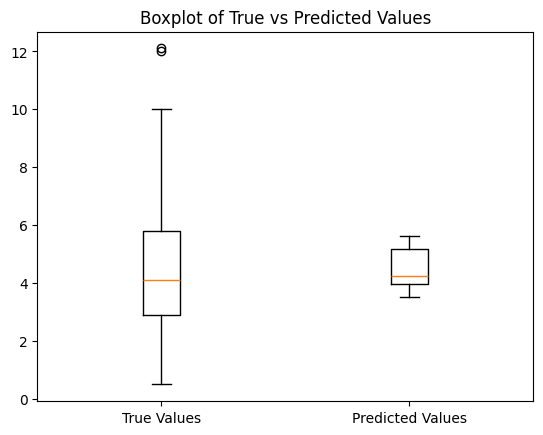

In [21]:
plt.boxplot([y, y_pred], tick_labels=["True Values", "Predicted Values"])
plt.title("Boxplot of True vs Predicted Values")
plt.show()

In [22]:
# #Base Line model with cross-validation

# #ler o X_test do ficheiro test_data.csv
# # df_test = pd.read_csv('./data/test_data.csv')
# # #quero dar drop do id e GeneticRisk e TreatmentResponse
# # X_test = df_test.drop(['id', 'GeneticRisk', 'TreatmentResponse','ComorbidityIndex'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create the pipeline with scaling and Linear Regression
# pipeline = make_pipeline(
#     StandardScaler(),  # Feature scaling
#     LinearRegression()  # Linear regression model
# )

# # Train the model
# pipeline.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = pipeline.predict(X_test)

# # Evaluate performance using MSE
# mse = mean_squared_error(y_test, y_pred)
# print(f"MSE: {mse}")

# # Calculate cMSE
# cMSE = error_metric(y_test, y_pred, 0)
# print(f"cMSE: {cMSE}")

# create_submission_file(y_pred, 'baseline-submission-01.csv')

# # Plot true vs predicted values
# plt.scatter(y_test, y_pred)
# plt.xlabel('True Values (y)')
# plt.ylabel('Predicted Values (y_hat)')
# plt.title('True vs Predicted Survival Time')
# plt.show()


## Task 2 - Nonlinear models

### Task 2.1 - Development